In [1]:
from glob import glob
import sys
sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("/scratch/group/csce435-f24/thicket")
import numpy as np
import pandas as pd
import thicket as th

import matplotlib.pyplot as plt


In [2]:
tk = th.Thicket.from_caliperreader(glob("*.cali"))


(2/2) Creating Thicket: 100%|██████████| 251/251 [00:07<00:00, 34.12it/s]


In [3]:
print(tk.tree(metric_column='Total time'))

  _____ _     _      _        _   
 |_   _| |__ (_) ___| | _____| |_ 
   | | | '_ \| |/ __| |/ / _ \ __|
   | | | | | | | (__|   <  __/ |_ 
   |_| |_| |_|_|\___|_|\_\___|\__|  v2024.1.0

18.637 main
├─ 0.249 MPI_Comm_dup
├─ 0.000 MPI_Finalize
├─ 0.000 MPI_Finalized
├─ 0.000 MPI_Init
├─ 0.000 MPI_Initialized
├─ 0.183 comm
│  └─ 0.183 comm_large
│     ├─ 0.021 MPI_Gather
│     └─ 0.161 MPI_Scatter
├─ 0.276 comp
│  └─ 0.275 comp_large
├─ 0.003 correctness_check
└─ 0.001 data_init_runtime

Legend (Metric: Total time Min: 0.00 Max: 18.64 indices: {'profile': 1625779})
█ 16.77 - 18.64
█ 13.05 - 16.77
█ 9.32 - 13.05
█ 5.59 - 9.32
█ 1.86 - 5.59
█ 0.00 - 1.86

name User code    ◀  Only in left graph    ▶  Only in right graph



In [4]:
tk.show_metric_columns()

['Variance time/rank',
 'Avg time/rank (exc)',
 'Min time/rank',
 'Total time (exc)',
 'Max time/rank (exc)',
 'Calls/rank (avg)',
 'Min time/rank (exc)',
 'Calls/rank (total)',
 'Calls/rank (min)',
 'Max time/rank',
 'Calls/rank (max)',
 'Avg time/rank',
 'Total time']

In [5]:
tk.metadata_column_to_perfdata("input_type")
input_types = sorted(tk.metadata["input_type"].unique())
tk.metadata_column_to_perfdata("input_size")
input_sizes = sorted(tk.metadata["input_size"].unique())
tk.metadata_column_to_perfdata("num_procs")
num_procs = sorted(tk.metadata["num_procs"].unique())
tk.dataframe = tk.dataframe.set_index(['input_type', 'input_size', 'num_procs'], append=True)




In [6]:
# ensuring all input types are present:
print(input_types)

['1_perc_perturbed', 'Random', 'ReverseSorted', 'Sorted']


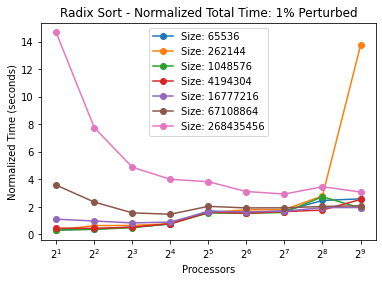

<Figure size 432x288 with 0 Axes>

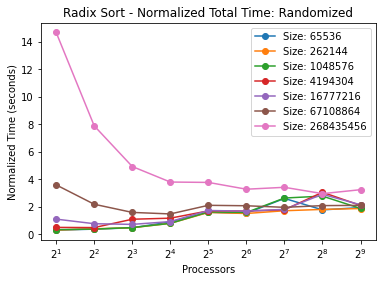

<Figure size 432x288 with 0 Axes>

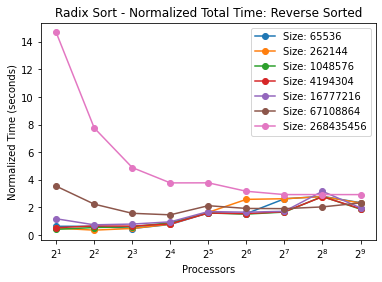

<Figure size 432x288 with 0 Axes>

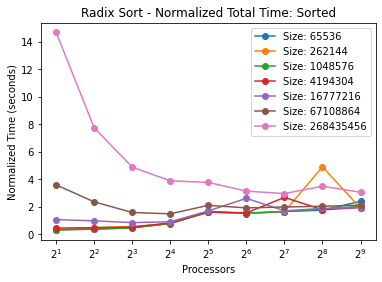

<Figure size 432x288 with 0 Axes>

In [18]:
titles = {
    "Sorted" : "Sorted", 
    "1_perc_perturbed": "1% Perturbed", 
    "Random" : "Randomized", 
    "ReverseSorted" : "Reverse Sorted"
}

for input_type in input_types:
    data = tk.dataframe.xs((input_type), level='input_type')
    
    x = num_procs  
    y_total_time = {input_size: [] for input_size in input_sizes} 
    y_max_time_rank = {input_size: [] for input_size in input_sizes}  
    
    for input_size in input_sizes:
        data_size = data.xs(input_size, level='input_size')
        
        for num_proc in num_procs:
            try:
                total_time_value = data_size.xs(num_proc, level='num_procs')["Total time"].tolist()
                normalized_total_time = total_time_value[0] / num_proc  
                y_total_time[input_size].append(normalized_total_time)  
                
                max_time_rank_value = data_size.xs(num_proc, level='num_procs')["Max time/rank"].tolist()
                y_max_time_rank[input_size].append(max_time_rank_value[0])  
            except KeyError:
                y_total_time[input_size].append(None) 
                y_max_time_rank[input_size].append(None)  
    plt.figure()
    for input_size, y_vals in y_total_time.items():
         plt.plot(x, y_vals, label=f'Size: {input_size}', marker='o')
    plt.xticks(x)
    plt.xscale('log', base=2)
    plt.legend()
    plt.xlabel('Processors')
    plt.ylabel('Normalized Time (seconds)')
    plt.title(f"Radix Sort - Normalized Total Time: {titles[input_type]}")
    
    file = f'./plots/Radix_Sort_Normalized_Total_Time_{titles[input_type].replace(" ", "_")}.png'
    plt.savefig(file)
    plt.show()

    plt.figure()
    

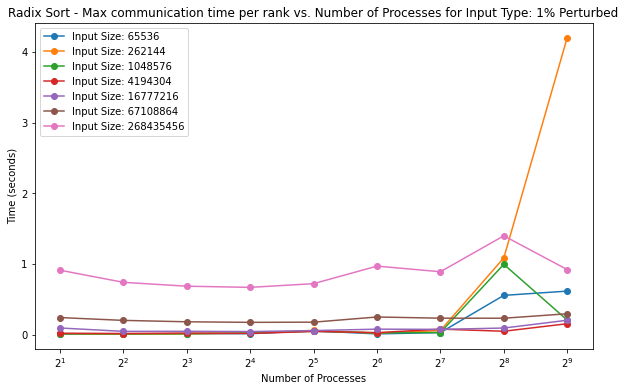

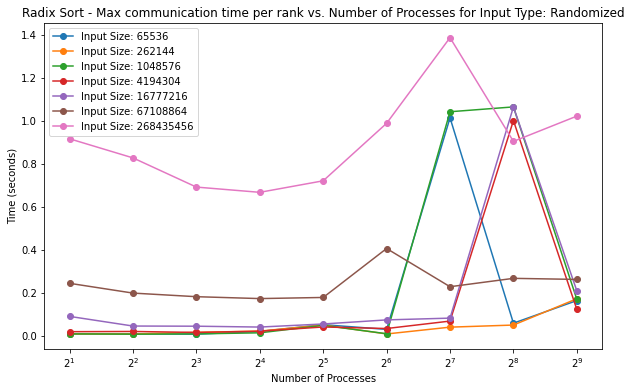

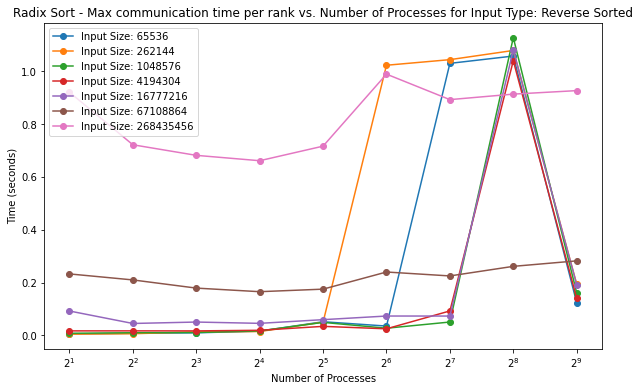

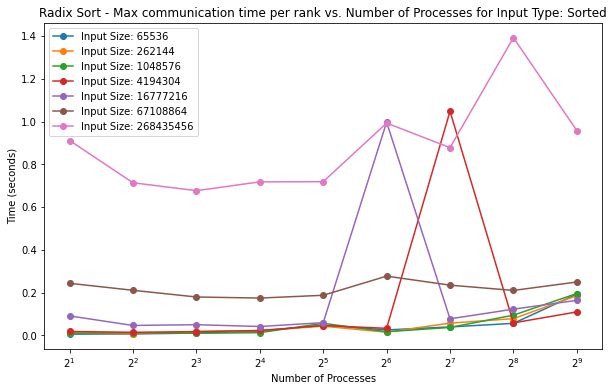

In [8]:
# communication plot
main_df = tk.dataframe.loc[tk.dataframe['name'] == 'comm']

for input_type in input_types:
    plt.figure(figsize=(10, 6))
    
    title = f"Radix Sort - Max communication time per rank vs. Number of Processes for Input Type: {titles[input_type]}"
    plt.title(title)

    input_type_df = main_df.xs(input_type, level='input_type')

    for input_size in input_sizes:
        try:
            input_size_df = input_type_df.xs(input_size, level='input_size')
            
            num_procs_vals = input_size_df.index.get_level_values('num_procs')
            max_comm_times = input_size_df['Max time/rank']
            
            sorted_indices = np.argsort(num_procs_vals)
            num_procs_sorted = num_procs_vals[sorted_indices]
            max_comm_times_sorted = max_comm_times.iloc[sorted_indices]

            plt.plot(num_procs_sorted, max_comm_times_sorted, label=f'Input Size: {input_size}', marker='o')
        
        # in case of outliers removed:
        except KeyError:
            print(f"Data missing for input size {input_size} in {input_type}")
            continue 

    plt.xscale('log', base=2)
    plt.xlabel('Number of Processes')
    plt.ylabel('Time (seconds)')
    plt.legend()
    
    file = f'./plots/Max_Comm_Time_{titles[input_type].replace(" ", "_")}.png'
    plt.savefig(file)
    plt.show()


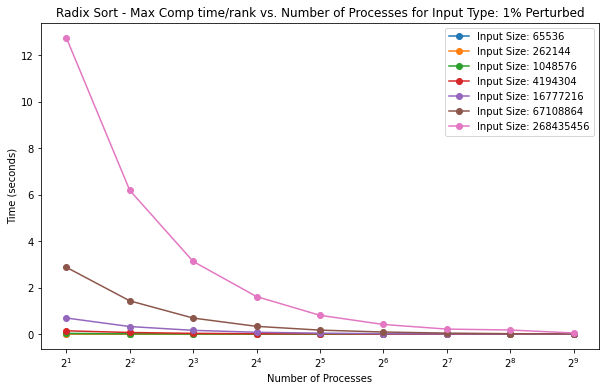

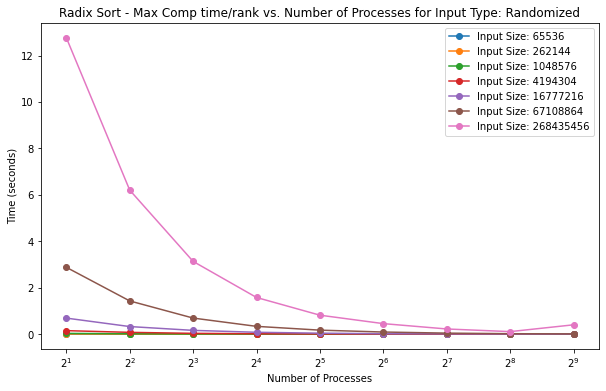

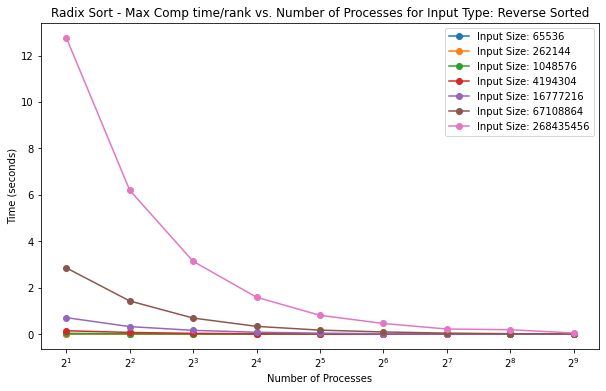

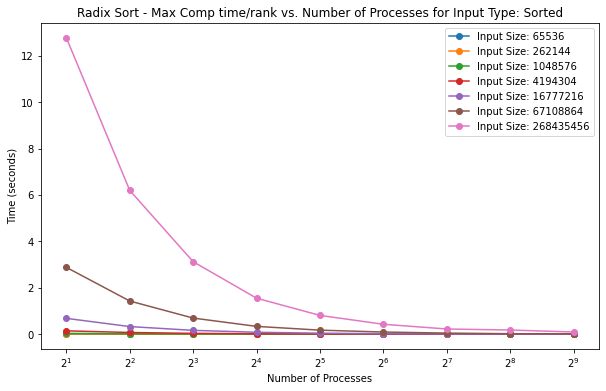

In [19]:
# max comp time/rank
main_df = tk.dataframe.loc[tk.dataframe['name'] == 'comp']

for input_type in input_types:
    plt.figure(figsize=(10, 6))
    
    title = f"Radix Sort - Max Comp time/rank vs. Number of Processes for Input Type: {titles[input_type]}"
    plt.title(title)

    input_type_df = main_df.xs(input_type, level='input_type')

    for input_size in input_sizes:
        try:
            input_size_df = input_type_df.xs(input_size, level='input_size')
            
            num_procs_vals = input_size_df.index.get_level_values('num_procs')
            max_time_rank = input_size_df['Max time/rank']
            
            sorted_indices = np.argsort(num_procs_vals)
            num_procs_sorted = num_procs_vals[sorted_indices]
            max_time_rank_sorted = max_time_rank.iloc[sorted_indices]

            plt.plot(num_procs_sorted, max_time_rank_sorted, label=f'Input Size: {input_size}', marker='o')
        
        # in case outliers are removed
        except KeyError:
            print(f"Data missing for input size {input_size} in {input_type}")
            continue  

    plt.xscale('log', base=2)
    plt.xlabel('Number of Processes')
    plt.ylabel('Time (seconds)')
    plt.legend()
    
    file = f'./plots/Max_Comp_Time_Rank_{titles[input_type].replace(" ", "_")}.png'
    plt.savefig(file)
    plt.show()